# Galaxy Decomposition

In [21]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from auriga.snapshot import Snapshot
from auriga.images import figure_setup, set_axs_configuration
from auriga.settings import Settings

In [22]:
figure_setup()

## The Decomposition Phase-Space

In [23]:
def read_data(simulation: str) -> tuple:
    """
    This method returns the circularity and the normalized potential for the
    stars in the main object of the simulation.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    tuple
        The circularity and normalized potential.
    """
    s = Snapshot(simulation=simulation,
                 loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    s.add_reference_to_potential()
    s.add_normalized_potential()
    s.tag_particles_by_region(disc_std_circ=1.0,
                              disc_min_circ=0.4,
                              cold_disc_delta_circ=0.25,
                              bulge_max_specific_energy=-0.75)

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    return (s.circularity[is_real_star & is_main_obj],
        s.normalized_potential[is_real_star & is_main_obj],
        s.region_tag[is_real_star & is_main_obj])

In [24]:
def add_panel_for_galaxy(simulation: str, ax: plt.Axes):
    """
    This method adds a panel with the results for a given simulation.

    Parameters
    ----------
    simulation : str
        The simulation.
    ax : plt.Axes
        The ax to which to add the plot.
    """

    circularity, potential, _ = read_data(simulation=simulation)
    _, _, _, im = ax.hist2d(circularity,
                            potential,
                            cmap='nipy_spectral',
                            bins=200,
                            range=[ax.get_xlim(), ax.get_ylim()],
                            norm=mcolors.LogNorm(vmin=1E0, vmax=1E3))
    ax.text(x=0.05,
            y=0.95,
            s=r"$\texttt{" + simulation.upper() + "}$",
            size=6.0, transform=ax.transAxes,
            ha='left', va='top',
            )

In [25]:
def plot_decomp_phases_for_sample(simulations: list,
                                  filename: str):
    """
    This method creates a plot of the phase space for galactic decomposition
    - the circularity in the x-axis and the normalized gravitational
    potential in the y-axis.

    Parameters
    ----------
    simulations : str
        A list of simulations to plot.
    filename : str
        The name of the output file.
    """

    n_simulations = len(simulations)

    fig = plt.figure(figsize=(7.2, 7.2))
    gs = fig.add_gridspec(nrows=6, ncols=5, hspace=0.0, wspace=0.0)
    axs = gs.subplots(sharex=True, sharey=True)

    set_axs_configuration(
        xlim=(-1.4, 1.4), ylim=(-1, 0),
        xticks=[-1, 0, 1], yticks=[-.8, -.6, -.4, -.2, 0],
        xlabel=r'$\epsilon = j_z \, j_\mathrm{circ}^{-1}$',
        ylabel=r'$\tilde{e} = e \, \left| e \right|_\mathrm{max}^{-1}$',
        axs=axs, n_used=n_simulations)

    for idx, ax in enumerate(axs.flat):
        if idx < n_simulations:
            add_panel_for_galaxy(simulations[idx], ax=ax)
        else:
            ax.axis("off")

    # cbar = fig.colorbar(im, ax=ax, orientation='vertical',
    #                     label=r'$N_\mathrm{stars}$',
    #                     pad=0)
    # cbar.ax.set_yticks([1E0, 1E1, 1E2, 1E3])

    for ext in ["pdf", "png"]:
        fig.savefig(
            f"../images/galaxy_decomposition/phase_space_{filename}.{ext}")
    plt.close(fig)

In [26]:
# Create plots for all galaxies in two figures
settings = Settings()
originals = [f"au{i}_or_l4_s127" for i in settings.galaxies]
reruns = [f"au{i}_re_l4_s251" for i in settings.reruns]
plot_decomp_phases_for_sample(simulations=originals,
                              filename="originals_s127")
plot_decomp_phases_for_sample(simulations=reruns,
                              filename="reruns_s251")

## Radial and Vertical Distribution of Particles

In [ ]:
def read_data_pos(simulation: str) -> tuple:
    """
    This method returns the region tag, radius in the disc plane and
    position in the z-axis for the stars in the main object.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    tuple
        The properties.
    """
    s = Snapshot(simulation=simulation,
                 loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    s.add_reference_to_potential()
    s.add_normalized_potential()
    s.tag_particles_by_region(disc_std_circ=1.0,
                              disc_min_circ=0.4,
                              cold_disc_delta_circ=0.25,
                              bulge_max_specific_energy=-0.75)

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    return (s.region_tag[is_real_star & is_main_obj],
        s.rho[is_real_star & is_main_obj],
        s.pos[is_real_star & is_main_obj, 2],)

In [ ]:
def plot_part_distribution_by_region(simulation: str):
    """
    This method creates a plot of the velocities as a function of radius in
    the disc plane for each component.

    Parameters
    ----------
    simulation : str
        The simulation to plot.
    """

    fig = plt.figure(figsize=(3.7, 2.0))
    gs = fig.add_gridspec(nrows=1, ncols=2, hspace=0.0, wspace=0.0)
    axs = gs.subplots(sharex=False, sharey=True)

    for ax in axs.flat:
        ax.grid(True, ls='-', lw=0.25, c='silver', zorder=-20)
        ax.tick_params(which='both', direction="in")
        ax.set_ylabel('PDF')
        ax.label_outer()

    axs[0].set_xlim(0, 50)
    axs[0].set_xticks([0, 10, 20, 30, 40])
    axs[1].set_xlim(-10, 10)
    axs[1].set_xticks([-10, -5, 0, 5, 10])
    axs[0].set_xlabel(r'$r_{xy}$ [ckpc]')
    axs[1].set_xlabel(r'$z$ [ckpc]')

    settings = Settings()
    region_tag, rho, z = read_data_pos(simulation=simulation)
    for idx, tag in enumerate(np.unique(region_tag)):
        is_region = (region_tag == tag)
        axs[0].hist(x=rho[is_region],
                    bins=100,
                    range=axs[0].get_xlim(),
                    histtype="step",
                    density=True,
                    color=settings.component_colors[settings.components[idx]],
                    label=settings.component_labels[settings.components[idx]])
        axs[1].hist(x=z[is_region],
                    bins=100,
                    range=axs[1].get_xlim(),
                    histtype="step",
                    density=True,
                    color=settings.component_colors[settings.components[idx]])

    axs[0].legend(loc="upper left", framealpha=0, fontsize=6.0)

    axs[0].text(x=axs[0].get_xlim()[0],
                y=axs[0].get_ylim()[1],
                s=r"$\texttt{" + simulation.upper() + "}$",
                size=8.0,
                ha='left', va='bottom',
                )

    plt.show()

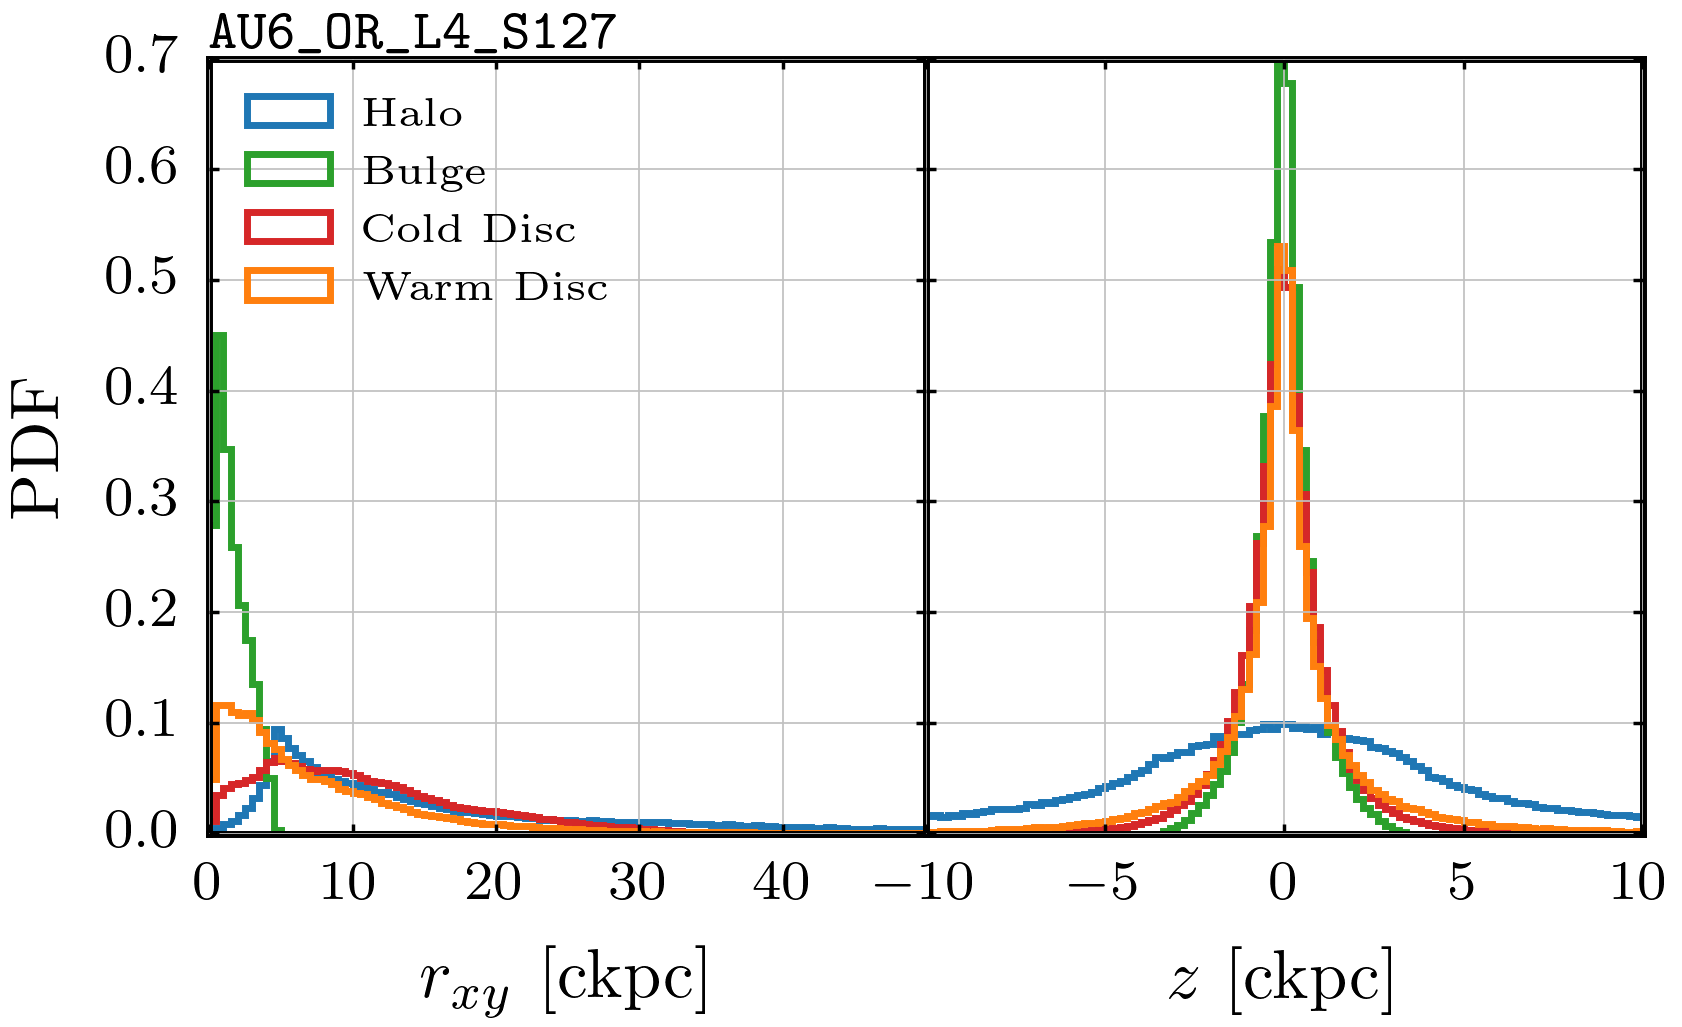

In [ ]:
plot_part_distribution_by_region(simulation="au6_or_l4_s127")

In [ ]:
def plot_height_vs_radius_for_halo(simulation: str):
    """
    This method creates a plot of the velocities as a function of radius in
    the disc plane for each component.

    Parameters
    ----------
    simulation : str
        The simulation to plot.
    """

    fig = plt.figure(figsize=(2.0, 2.0))
    gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
    ax = gs.subplots(sharex=False, sharey=True)

    ax.grid(True, ls='-', lw=0.25, c='silver', zorder=-20)
    ax.tick_params(which='both', direction="in")
    ax.label_outer()
    ax.set_xlim(0, 5)
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_ylim(-25, 25)
    ax.set_yticks([-20, -10, -5, 0, 5, 10, 20])
    ax.set_xlabel(r'$r_{xy}$ [ckpc]')
    ax.set_ylabel(r'$z$ [ckpc]')

    settings = Settings()
    region_tag, rho, z = read_data_pos(simulation=simulation)
    is_region = (region_tag == 0)
    ax.scatter(x=rho[is_region],
               y=z[is_region],
               s=0.1,
               zorder=10,
               color=settings.component_colors[settings.components[0]])

    ax.text(x=ax.get_xlim()[0],
            y=ax.get_ylim()[1],
            s=r"$\texttt{" + simulation.upper() + "}$",
            size=8.0,
            ha='left', va='bottom',
            )

    plt.show()

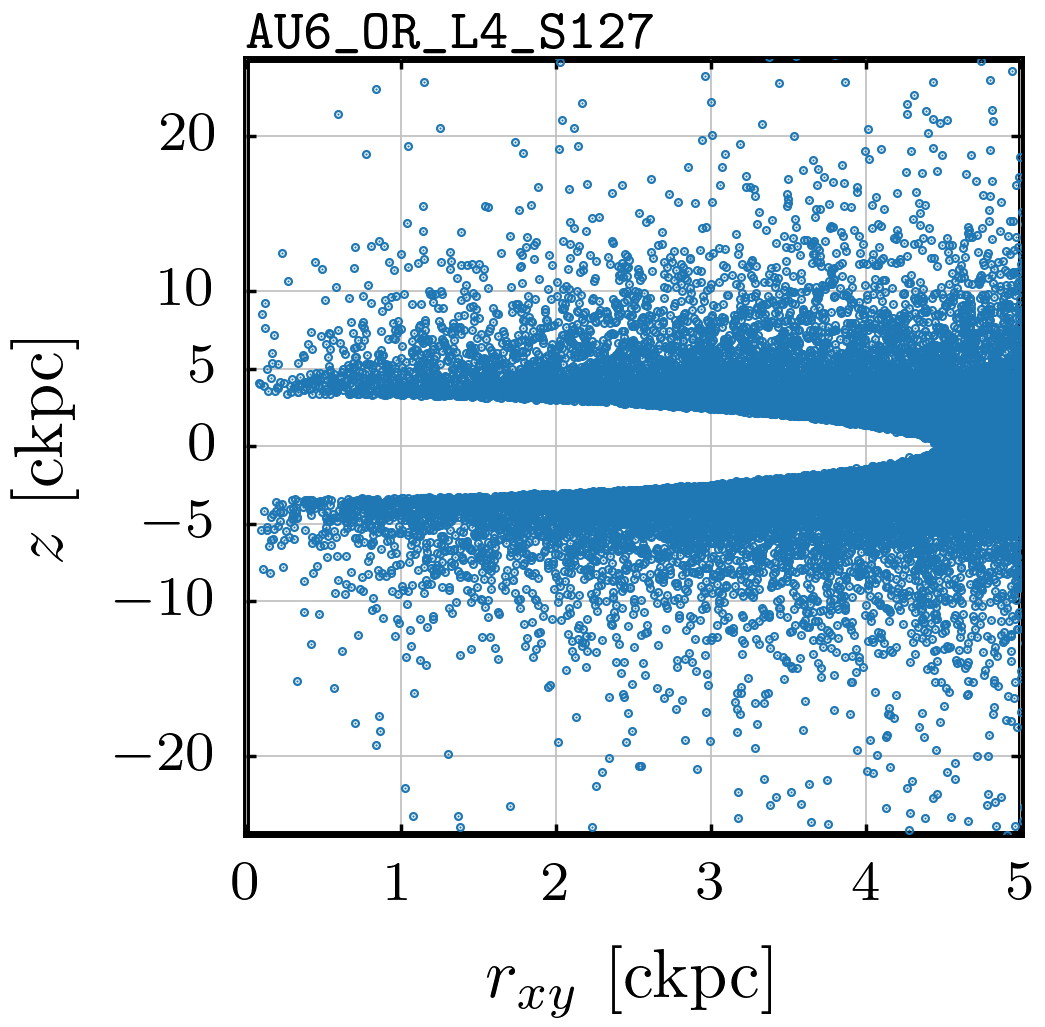

In [ ]:
plot_height_vs_radius_for_halo(simulation="au6_or_l4_s127")